<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2D_CNN_colab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Wed Jul 14 11:59:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [4]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [46]:
train_normal = []
test_normal = []
train_smurf = []
test_smurf = []
train_ip = []
test_ip = []
train_port = []
test_port = []
train_nmap = []
test_nmap = []

for i in glob.glob('/content/split_images/64x64_V2/70-30/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/64x64_V2/70-30/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/64x64_V2/70-30/train_smurf/train_smurf_equ_*.jpg', recursive=True):
    train_smurf.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/64x64_V2/70-30/test_smurf/test_smurf_equ_*.jpg', recursive=True):
    test_smurf.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

for m in glob.glob('/content/split_images/64x64_V2/70-30/train_ip/train_ip_equ_*.jpg', recursive=True):
    train_ip.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))

for n in glob.glob('/content/split_images/64x64_V2/70-30/test_ip/test_ip_equ_*.jpg', recursive=True):
    test_ip.append(cv2.imread(n, cv2.IMREAD_GRAYSCALE))
    
for o in glob.glob('/content/split_images/64x64_V2/70-30/train_port/train_port_equ_*.jpg', recursive=True):
    train_port.append(cv2.imread(o, cv2.IMREAD_GRAYSCALE))

for p in glob.glob('/content/split_images/64x64_V2/70-30/test_port/test_port_equ_*.jpg', recursive=True):
    test_port.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE))
    
for q in glob.glob('/content/split_images/64x64_V2/70-30/train_nmap/train_nmap_equ_*.jpg', recursive=True):
    train_nmap.append(cv2.imread(q, cv2.IMREAD_GRAYSCALE))

for r in glob.glob('/content/split_images/64x64_V2/70-30/test_nmap/test_nmap_equ_*.jpg', recursive=True):
    test_nmap.append(cv2.imread(r, cv2.IMREAD_GRAYSCALE))
    


train_normal = np.array(train_normal)
test_normal = np.array(test_normal)
train_smurf = np.array(train_smurf)
test_smurf = np.array(test_smurf)
train_ip = np.array(train_ip)
test_ip = np.array(test_ip)
train_port = np.array(train_port)
test_port = np.array(test_port)
train_nmap = np.array(train_nmap)
test_nmap = np.array(test_nmap)

In [47]:
print(f'Normal train\t{np.shape(train_normal)}\nNormal test\t{np.shape(test_normal)}\nSmurf train\t{np.shape(train_smurf)}\nSmurf test\t{np.shape(test_smurf)}\nIP train\t{np.shape(train_ip)}\nIP test\t\t{np.shape(test_ip)}')
print(f'Port train\t{np.shape(train_port)}\nPort test\t{np.shape(test_port)}\nNmap train\t{np.shape(train_nmap)}\nNmap test\t{np.shape(test_nmap)}')

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

Normal train	(1500, 64, 64)
Normal test	(643, 64, 64)
Smurf train	(107, 64, 64)
Smurf test	(46, 64, 64)
IP train	(4757, 64, 64)
IP test		(2039, 64, 64)
Port train	(1557, 64, 64)
Port test	(667, 64, 64)
Nmap train	(56, 64, 64)
Nmap test	(24, 64, 64)


In [48]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_normal = np.fliplr(train_normal)
vert_flip_train_smurf = np.fliplr(train_smurf)
vert_flip_train_ip = np.fliplr(train_ip)
vert_flip_train_port = np.fliplr(train_port)
vert_flip_train_nmap = np.fliplr(train_nmap)

## flip training images horizonatally
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)
hor_flip_train_smurf = np.rot90(train_smurf, axes = (1,2), k = 2)
hor_flip_train_ip = np.rot90(train_ip, axes = (1,2), k = 2)
hor_flip_train_port = np.rot90(train_port, axes = (1,2), k = 2)
hor_flip_train_nmap = np.rot90(train_nmap, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_normal = np.fliplr(test_normal)
vert_flip_test_smurf = np.fliplr(test_smurf)
vert_flip_test_ip = np.fliplr(test_ip)
vert_flip_test_port = np.fliplr(test_port)
vert_flip_test_nmap = np.fliplr(test_nmap)

## flip testing images horizonatally
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)
hor_flip_test_smurf = np.rot90(test_smurf, axes = (1,2), k = 2)
hor_flip_test_ip = np.rot90(test_ip, axes = (1,2), k = 2)
hor_flip_test_port = np.rot90(test_port, axes = (1,2), k = 2)
hor_flip_test_nmap = np.rot90(test_nmap, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, train_smurf, vert_flip_train_smurf, hor_flip_train_smurf, train_ip, vert_flip_train_ip, hor_flip_train_ip, train_port, vert_flip_train_port, hor_flip_train_port, train_nmap, vert_flip_train_nmap, hor_flip_train_nmap))
test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, test_smurf, vert_flip_test_smurf, hor_flip_test_smurf, test_ip, vert_flip_test_ip, hor_flip_test_ip, test_port, vert_flip_test_port, hor_flip_test_port, test_nmap, vert_flip_test_nmap, hor_flip_test_nmap))

In [7]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_smurf, train_ip, train_port, train_nmap))
test = np.vstack((test_normal, test_smurf, test_ip, test_port, test_nmap))

train.shape, test.shape

((6837, 64, 64), (4559, 64, 64))

In [49]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((23931, 64, 64, 1), (10257, 64, 64, 1))

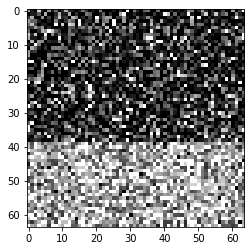

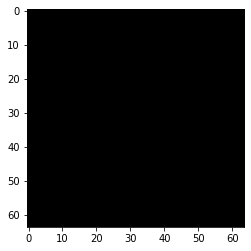

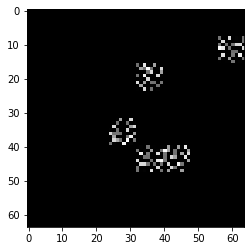

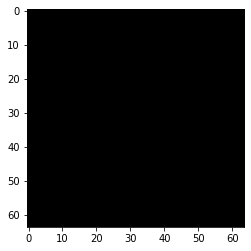

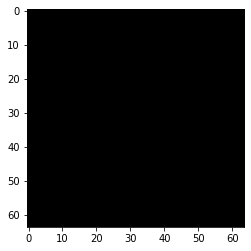

In [11]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [9]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []

for i in range(0, train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [21]:
pd.DataFrame(training_labels)

,0
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
6832,Nmap-Sweep
6833,Nmap-Sweep
6834,Nmap-Sweep
6835,Nmap-Sweep


In [50]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [ ]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [51]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0             0           0       1           0           0
 1             0           0       1           0           0
 2             0           0       1           0           0
 3             0           0       1           0           0
 4             0           0       1           0           0
 ...         ...         ...     ...         ...         ...
 23926         0           1       0           0           0
 23927         0           1       0           0           0
 23928         0           1       0           0           0
 23929         0           1       0           0           0
 23930         0           1       0           0           0
 
 [23931 rows x 5 columns],
        IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0             0           0       1           0           0
 1             0           0       1           0           0
 2             0           0       1           0        

In [52]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 42)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 42)

In [53]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation = 'softmax'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 64, 64, 16)        80        
_________________________________________________________________
average_pooling2d_52 (Averag (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
average_pooling2d_53 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
average_pooling2d_54 (Averag (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 8, 8, 128)       

In [54]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 256, epochs = 300)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
94/94 [==============================] - 3s 31ms/step - loss: 1.0957 - accuracy: 0.6463
Epoch 2/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8879 - accuracy: 0.6601
Epoch 3/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8730 - accuracy: 0.6700
Epoch 4/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8612 - accuracy: 0.6801
Epoch 5/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8538 - accuracy: 0.6846
Epoch 6/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8503 - accuracy: 0.6881
Epoch 7/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8386 - accuracy: 0.6925
Epoch 8/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8330 - accuracy: 0.6966
Epoch 9/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8286 - accuracy: 0.6996
Epoch 10/300
94/94 [==============================] - 3s 29ms/step - loss: 0.8165 - accuracy: 0.7037

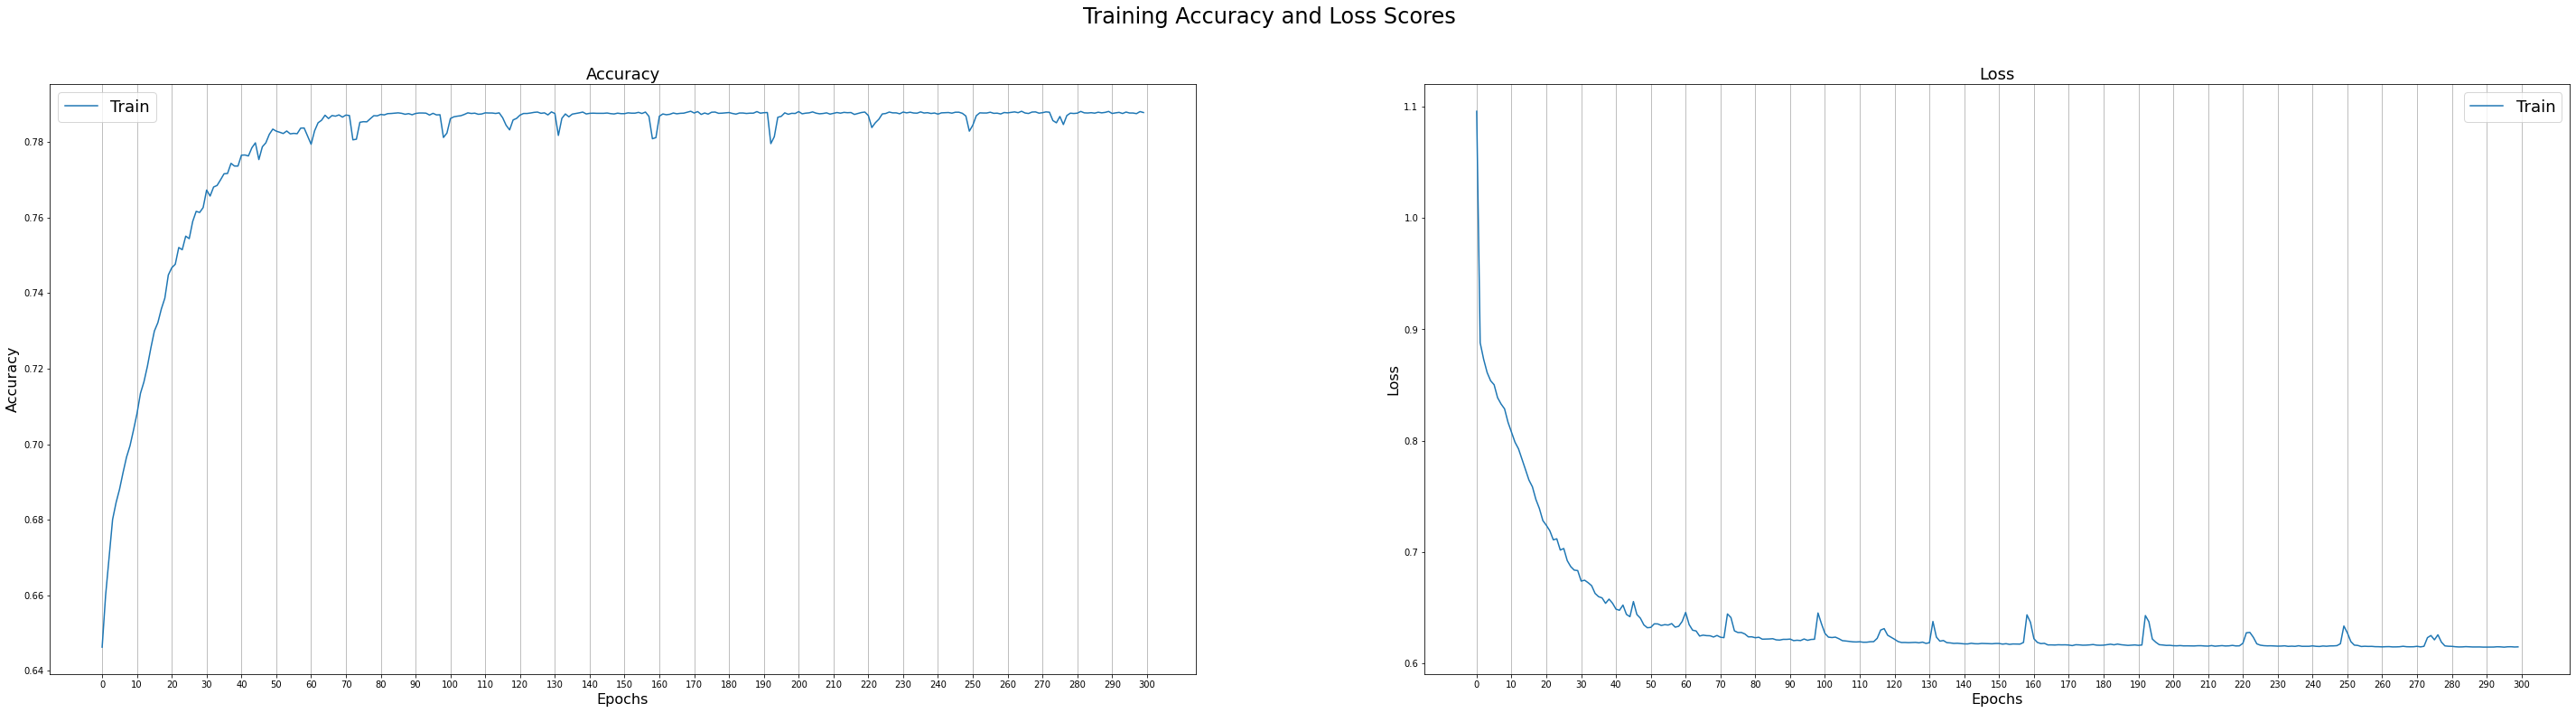

In [55]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [56]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 256, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.5356	Accuracy = 66.75%


In [57]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

print('\tIP\tNmap\tNormal\tPort\tSmurf\n')
preds[:20]

	IP	Nmap	Normal	Port	Smurf



array([[0.0003 , 0.     , 0.99924, 0.00045, 0.00001],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.79254, 0.     , 0.     , 0.20746, 0.     ],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.00002, 0.     , 0.00198, 0.96721, 0.0308 ],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.72526, 0.     , 0.00133, 0.27341, 0.     ],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.     , 0.00003, 0.99996, 0.00001, 0.     ],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.10907, 0.15685, 0.01276],
       [0.71859, 0.00273, 0.

In [58]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(64, activation='relu'))
    # cnn.add(Dense(32, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(5, activation = 'softmax'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 300)

In [59]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

Epoch 1/300
33/33 [==============================] - 1s 29ms/step - loss: 1.4725 - accuracy: 0.6206
Epoch 2/300
33/33 [==============================] - 1s 28ms/step - loss: 0.9226 - accuracy: 0.6539
Epoch 3/300
33/33 [==============================] - 1s 28ms/step - loss: 0.9052 - accuracy: 0.6579
Epoch 4/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8931 - accuracy: 0.6581
Epoch 5/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8807 - accuracy: 0.6618
Epoch 6/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8648 - accuracy: 0.6707
Epoch 7/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8551 - accuracy: 0.6761
Epoch 8/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8460 - accuracy: 0.6868
Epoch 9/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8437 - accuracy: 0.6857
Epoch 10/300
33/33 [==============================] - 1s 28ms/step - loss: 0.8254 - accuracy: 0.6979